Автор: Павел Любовин    
chistota@mail.ru   

# Прогноз состава корзины следующего заказа

Ссылка на соревнование:
https://www.kaggle.com/c/sbermarket-internship-competition

Описание задачи:
На основании данных о заказах пользователей предсказать какие категории товаров будут заказаны в следующий раз.

Формат данных о заказах:

    - user_id - уникальный id пользователя
    - order_completed_at - дата заказа
    - cart - список уникальных категорий (category_id), из которых состоял заказ

Формат прогноза:
    
    - id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
    - target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя
    
Прогноз необходимо сделать именно для тех пар {user_id};{category_id}, которые представлены в sample_submission.csv

# Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [4]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])  # Привожу к дате-времени

In [5]:
sample_out_df = pd.read_csv('sample_submission.csv')

In [6]:
sample_out_df.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


# Эксплоративный анализ

In [7]:
#Найдем всех уникальных пользователей и товары в выходном файле (т.е. те сущности, которые надо предсказать)
sample_out_df['user_category'] = sample_out_df['id'].apply(lambda x: x.split(';'))

In [8]:
sample_out_df['user'] = sample_out_df['user_category'].apply(lambda x: int(x[0]))
sample_out_df['category'] = sample_out_df['user_category'].apply(lambda x: int(x[1]))

In [9]:
sample_out_df.head()

,id,target,user_category,user,category
0,0;133,0,"[0, 133]",0,133
1,0;5,1,"[0, 5]",0,5
2,0;10,0,"[0, 10]",0,10
3,0;396,1,"[0, 396]",0,396
4,0;14,0,"[0, 14]",0,14


In [10]:
out_users = pd.unique(sample_out_df['user'])
out_categories = pd.unique(sample_out_df['category'])

In [11]:
print('Количество записей в выходном файле::', len(sample_out_df))
print('Количество уникальных пользователей в выходном файле:', len(out_users))
print('Количество уникальных категорий в выходном файле:', len(out_categories))

Количество записей в выходном файле:: 790449
Количество уникальных пользователей в выходном файле: 13036
Количество уникальных категорий в выходном файле: 858


In [12]:
# Теперь исследуем тренировочный датасет
print('Количество записей в тренировочном датасете:', len(df))
print('Количество уникальных пользователей в тренировочном датасете:', len(pd.unique(df['user_id'])))
print('Количество уникальных категорий в тренировочном датасете:', len(pd.unique(df['cart'])))

Количество записей в тренировочном датасете: 3123064
Количество уникальных пользователей в тренировочном датасете: 20000
Количество уникальных категорий в тренировочном датасете: 881


Как видно, в тренировочных данных присутствует бОльшее количество пользователи и категорий,
чем те, которые надо предсказать.
Сделаю предположение, что от этих лишних пользователей и категорий можно избавиться,
т.к. они, скорее всего, не несут большого смысла в рамках этой конкретной задачи. (Но это не точно )))

In [13]:
df_cut = df.loc[df['user_id'].isin(out_users) & df['cart'].isin(out_categories)]

In [14]:
# Смотрим, что получилось после удаления лишних записей
print('Количество записей в тренировочном датасете после удаления:', len(df_cut))
print('Исходный датасет уменьшился на', round(100 * (len(df) - len(df_cut)) / len(df), 2), '%')

Количество записей в тренировочном датасете после удаления: 2395657
Исходный датасет уменьшился на 23.29 %


In [15]:
# Еще раз проверим совпадает ли количество пользователей и категорий в тренировочном датасете и в выходном файле
print('Пользователей в датасете:', len(pd.unique(df_cut['user_id'])))
print('Пользователей в выходном файле:', len(out_users))
print('Категорий в датасете:', len(pd.unique(df_cut['cart'])))
print('Категорий в выходном файле:', len(out_categories))

Пользователей в датасете: 13036
Пользователей в выходном файле: 13036
Категорий в датасете: 858
Категорий в выходном файле: 858


Ура! Все совпадает!

## Новая сущность - Заказ

Введем понятие заказа - множество категорий, заказанное одним клиентом в одно время.

In [16]:
# Но сначала проверим, нет ли в датасете полных дублей (т.е. повторов категорий в одном заказе)
df_cut.drop_duplicates(inplace=True)

<ipython-input-16-ec155f474e09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.drop_duplicates(inplace=True)


In [17]:
len(df_cut)

2395657

Длина датасета НЕ изменилась, значит дублей не было.
Тот, кто готовил датасет - молодец!

In [ ]:
# Формирую датасет с заказами:
orders_df = df_cut.groupby(['user_id', 'order_completed_at'])['cart'].apply(set).to_frame().reset_index()

In [99]:
# И сразу добавим размер заказа (в товарных позициях)
orders_df['len_cart'] = orders_df['cart'].apply(lambda x: len(x))

In [100]:
orders_df.head()

,user_id,order_completed_at,cart,len_cart
0,0,2020-07-19 09:59:17,"{14, 430, 82, 20, 405, 441, 379, 57}",8
1,0,2020-08-24 08:55:32,"{5, 133, 10, 396, 14, 402, 405, 22, 409, 25, 2...",25
2,0,2020-09-02 07:38:25,"{803, 169, 170, 398, 399, 401, 84, 55, 440, 57...",11
3,1,2019-05-08 16:09:41,{55},1
4,1,2020-01-17 14:44:23,"{421, 204, 82, 86, 55, 798}",6


## Поисследуем заказы:

In [101]:
print('Количество заказов:', len(orders_df))
print('Заказов на одного пользователя:', round(len(orders_df) / len(out_users), 2))

Количество заказов: 160557
Заказов на одного пользователя: 12.32


In [102]:
# Что у нас с размером заказа?
orders_df['len_cart'].describe().to_frame()

,len_cart
count,160557.000000
mean,14.920913
std,8.772478
min,1.000000
25%,9.000000
50%,13.000000
75%,19.000000
max,120.000000


Медиана: 13 позиций в заказе, Среднее: ~15 позиций.

<AxesSubplot:xlabel='order_completed_at'>

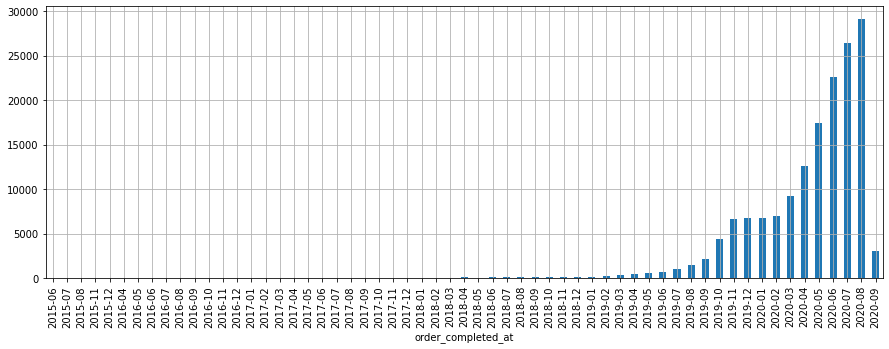

In [107]:
# Посмотрим заказы по месяцам
# orders_df['order_completed_at'] = pd.to_datetime(orders_df['order_completed_at'])  # Привожу к дате-времени
orders_df.groupby(orders_df['order_completed_at'].dt.to_period('M')).size().plot.bar(rot=90, grid=True, figsize=(15, 5))

Наблюдается экспоненциальный рост.
Но есть сомнения, что данные из 2015 года полезны в 2020.

# Начинаем делать submissions (разведка)

In [190]:
sub_df = pd.read_csv('sample_submission.csv')

In [110]:
sub_df.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


Первые submissions будут разведочными. Я попробую понять, какие результаты можно получить без всякого ML.
Возможно, это кому-то покажется читами. Но я использую для решения всю доступную мне информацию.

In [114]:
# Заполняю ответ одними нулями
sub_df['target'] = 0
sub_df.to_csv('sub1.csv', index=False)
# Результат: Score = 0.00000

In [115]:
# Заполняю ответ одними единицами
sub_df['target'] = 1
sub_df.to_csv('sub2.csv', index=False)
# Score = 0.30632

Вуаля! Результат sample_submission побит!
Отсюда делаем предварительный вывод: не знаешь, что предсказывать - предсказывай 1!
Но лучше ли это случайного предсказания?

In [126]:
# Заполняю таргет нулями и единицами случайным образом.
# Для верности - 3 раза
np.random.seed(0)
sub_df['target'] = np.random.randint(0, 2, sub_df.shape[0])
sub_df.to_csv('sub3.csv', index=False)  # Score = 0.26419

np.random.seed(1)
sub_df['target'] = np.random.randint(0, 2, sub_df.shape[0])
sub_df.to_csv('sub4.csv', index=False)  # Score = 0.26659

np.random.seed(2)
sub_df['target'] = np.random.randint(0, 2, sub_df.shape[0])
sub_df.to_csv('sub5.csv', index=False)  # Score = 0.26586

Выводы:
    - случайное заполнение дает score ~0.265
    - все, что выше этого порога - считаем, что нашли какую-то закономерность в данных
    - если что-то получится ниже этого порога, то надо попробовать сделать наоборот
На текущий момент лучшая стратегия - всегда предсказывать единицы.

# Гипотеза 1 - Невостребованные товары

Т.к. по умолчанию у нас таргет == 1, то пробую найти ситуации, тогда лучше предказывать 0
Например, если пользователь ни разу не заказывал какой-то товар, то, наверное,
в будущем заказе этого товара тоже не будет.
Или другими словами: класть в следующий заказ ВСЁ и только то, что он заказывал ранее.
Проверим это предположение

In [257]:
df_cut2 = df_cut.groupby(['user_id', 'cart']).count().reset_index()  \
    .rename({'user_id': 'user', 'cart':'category', 'order_completed_at': 'orders_count'}, axis=1)

In [236]:
# Считаю кол-во раз, сколько товар был заказан конкретным пользователем
df_cut2.head()

,user,category,orders_count
0,0,5,1
1,0,10,1
2,0,14,2
3,0,20,1
4,0,22,1


In [234]:
# Объединяю информацю из выходного файла (тот, который надо предсказать)
# с информацией по количеству тому, сколько конкретный пользователь заказал конкретный товар
sample_out_df2 = pd.merge(sample_out_df, df_cut2, left_on=['user', 'category'], right_on=['user', 'category'])

In [237]:
sample_out_df2.head()

,id,target,user_category,user,category,orders_count
0,0;133,0,"[0, 133]",0,133,1
1,0;5,1,"[0, 5]",0,5,1
2,0;10,0,"[0, 10]",0,10,1
3,0;396,1,"[0, 396]",0,396,1
4,0;14,0,"[0, 14]",0,14,2


In [238]:
# А теперь ищу в нем NAN, то есть те сочетания пользователь-товар, которые ни разу не встретились в заказах
sample_out_df2['orders_count'].isna().sum()

0

А их нет!
Я сделал открытие: требуется предсказывать только то, что пользователь заказал хотя бы однажды
Проверим еще раз этот факт:

In [239]:
len(sample_out_df2) == len(df_cut2)

True

Длины фреймов совпадают. Так и должно быть.

# Гипотеза 2 - Популярные товары

In [ ]:
Теперь попробую предсказывать 1 только для популярных товаров. А для непопулярных - 0.

In [261]:
df_cut3 = df_cut.groupby('cart')['order_completed_at'].count().to_frame().reset_index()  \
        .rename({'order_completed_at': 'orders_count'}, axis=1)  \
        .sort_values(by='orders_count', ascending=False)

In [265]:
df_cut3.head()

,cart,orders_count
56,57,83722
14,14,72214
60,61,70478
393,398,63190
23,23,55231


<AxesSubplot:>

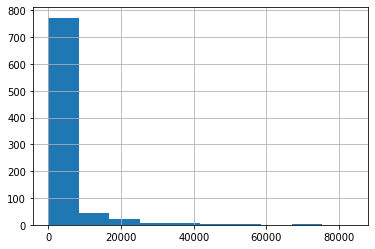

In [266]:
df_cut3['orders_count'].hist()

In [267]:
df_cut3['orders_count'].describe()

count      858.000000
mean      2792.141026
std       8308.651958
min          1.000000
25%          6.000000
50%         55.500000
75%        903.000000
max      83722.000000
Name: orders_count, dtype: float64

В качестве ориентира возьму медиану.
То есть буду считать товар НЕпопулярным, если его заказали 55 раз или меньше.
И предсказывать для таких непопулярных товаров 0.

In [275]:
sample_out_df2 = sample_out_df2.merge(df_cut3, left_on='category', right_on='cart') \
    .drop('cart', axis=1)  \
    .rename({'orders_count_x': 'user_orders_count', 'orders_count_y': 'total_orders_count'}, axis=1)

In [392]:
sample_out_df2.head()

,id,target,user_category,user,category,user_orders_count,total_orders_count
0,0;133,0,"[0, 133]",0,133,1,1099
1,4;133,1,"[4, 133]",4,133,1,1099
2,16;133,0,"[16, 133]",16,133,2,1099
3,18;133,1,"[18, 133]",18,133,2,1099
4,21;133,0,"[21, 133]",21,133,9,1099


In [277]:
sub_df = sample_out_df2.copy()

In [281]:
sub_df['target'] = (sub_df['total_orders_count'] > 55).astype(int)

In [286]:
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub6.csv', index=False)   # Score = 0.30769
# Новый рекорд, но улучшение незначительное

In [287]:
# Попробую теперь предсказывать 0 для еще менее популярных товаров
# 25-перцентиль равен 6
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 6).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub7.csv', index=False)   # Score = 0.30647
# Результат стал немного хуже, но чуть лучше, чем предсказывать всегда 1

In [383]:
# Пробую 75-перцентиль, который равен 903
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 903).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub8.csv', index=False)   # Score = 0.32222
# Новый рекорд!

In [384]:
# 2000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 2000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub11.csv', index=False)   # Score = 0.33502
# Новый рекорд!

In [385]:
# 3000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 3000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub12.csv', index=False)   # Score = 0.34500
# Новый рекорд!

In [386]:
# 5000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 5000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub13.csv', index=False)   # Score = 0.35555
# Новый рекорд!

In [387]:
# 10000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 10000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub14.csv', index=False)   # Score = 0.37692
# Новый рекорд!

In [389]:
# 20000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 20000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub15.csv', index=False)   # Score = 0.40912
# Новый рекорд!
# simple baseline побежден!

In [390]:
# 40000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 40000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub16.csv', index=False)   # Score = 0.34236
# Существенное падение результата

In [391]:
# 30000
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['total_orders_count'] > 30000).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub17.csv', index=False)   # Score = 0.40336
# Хуже, чем 20000

# Гипотеза 3 - Популярные товары конкретного пользователя

Представим, что ожидаемый от нас прогноз - это вероятность того, что товар будет заказан пользователем.
Если вероятность >= 0.5 (скорее всего, закажет), то логично предсказать 1,
если меньше 0.5 (скорее всего, не закажет), то предсказать 0.

Будем брать последние 10 заказов пользователя (или сколько есть).
Для товаров, которые встретились в половине этих заказов или более, будем предсказывать 1, иначе 0.

In [308]:
N = 10

In [309]:
# Последние N заказов каждого пользователя
ordersN_df = orders_df.sort_values(['user_id', 'order_completed_at'], ascending=[True, False])  \
    .groupby('user_id').head(N)

In [357]:
# Теперь надо узнать, сколько этих самых последних заказов у каждого пользователя
last_user_N_orders_count_df = ordersN_df.groupby('user_id')['cart'].count().to_frame().reset_index()  \
        .rename({'cart':'last_user_N_orders'}, axis=1)

In [359]:
last_user_N_orders_count_df.head()

,user_id,last_user_N_orders
0,0,3
1,1,9
2,3,7
3,4,8
4,5,10


In [326]:
# Основной фрейм, но только с данными за последние N заказов
df_cut4 = df_cut[df_cut['user_id'].isin(ordersN_df['user_id']) \
                & df_cut['order_completed_at'].isin(ordersN_df['order_completed_at'])]

In [329]:
df_cut4.head()

,user_id,order_completed_at,cart
16,3,2015-06-18 16:15:33,399
17,3,2015-07-04 14:05:22,399
18,4,2015-07-08 06:59:04,54
19,4,2015-07-08 06:59:04,55
34,3,2015-08-12 10:33:44,804


In [361]:
# Сколько раз в последних заказах пользователя присутствовала конкретная категория
category_df = df_cut4.groupby(['user_id', 'cart']).count().reset_index()  \
            .rename({'order_completed_at': 'orders_count'}, axis=1)
# Теперь добавлю информацию о количестве последних заказов
category_df = category_df.merge(last_user_N_orders_count_df, on='user_id')

In [362]:
category_df.head()

,user_id,cart,orders_count,last_user_N_orders
0,0,5,1,3
1,0,10,1,3
2,0,14,2,3
3,0,20,1,3
4,0,22,1,3


In [365]:
# Фрейм только с теми категориями, которые пользователь заказывал в половине своих последних заказов или чаще
category_top_df = category_df[category_df['orders_count'] >= category_df['last_user_N_orders'] / 2] 

In [367]:
category_top_df.head()

,user_id,cart,orders_count,last_user_N_orders
2,0,14,2,3
9,0,57,3,3
11,0,82,2,3
13,0,84,2,3
18,0,379,2,3


In [375]:
# Готовлю submission
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['user'].isin(category_top_df['user_id']) \
                    & sub_df['category'].isin(category_top_df['cart'])).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub9.csv', index=False)   # Score = 0.31222
# Результат улучшить не удалось

# Гипотеза 4 - Следующий заказ совпадает с предыдущим

Для временных рядов часто оказывается, что хорошим предсказанием является просто предыдущее значение ряда.
То есть следующий заказ пользователя будет максимально похож на предыдущий.
Проверим это предположение.
Буду предсказывать 1, если товар был в последнем заказе. Иначе - 0.

In [ ]:
N = 1

In [376]:
# Последний заказ каждого пользователя
orders1_df = orders_df.sort_values(['user_id', 'order_completed_at'], ascending=[True, False])  \
    .groupby('user_id').head(1)

In [378]:
# Основной фрейм, но только с данными из последнего заказа
df_cut5 = df_cut[df_cut['user_id'].isin(orders1_df['user_id']) \
                & df_cut['order_completed_at'].isin(orders1_df['order_completed_at'])]

In [382]:
# Готовлю submission
sub_df = sample_out_df2.copy()
sub_df['target'] = (sub_df['user'].isin(df_cut5['user_id']) \
                    & sub_df['category'].isin(df_cut5['cart'])).astype(int)
sub_df = sub_df.loc[:, ['id', 'target']]
sub_df.to_csv('sub10.csv', index=False)   # Score = 0.30666
# Результат улучшить не удалось

На этом простые гипотезы закончились.
Пора приступать к машинному обучению.
Ему посвящен 2-й ноутбук: Cart_forecast_LSTM_v2(combat).ipynb